In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats

In [22]:
file_path = "Mall_Customers.csv"
df = pd.read_csv(file_path)
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [23]:
# Drop CustomerID as it's not needed for clustering
df = df.drop(columns=['CustomerID'])

# Convert Gender column to numeric values (Male = 0, Female = 1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [24]:
# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(df[['Annual Income (k$)', 'Spending Score (1-100)']]))
df = df[(z_scores < 3).all(axis=1)]

print(df.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6
3       1   23                  16                      77
4       1   31                  17                      40


In [25]:
# Select features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

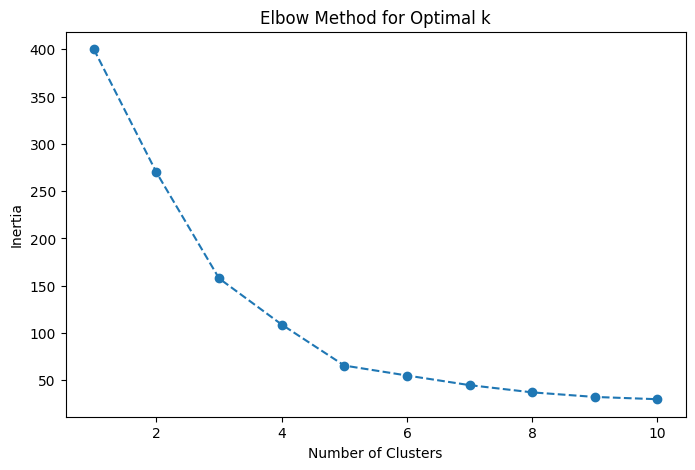

In [27]:
# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

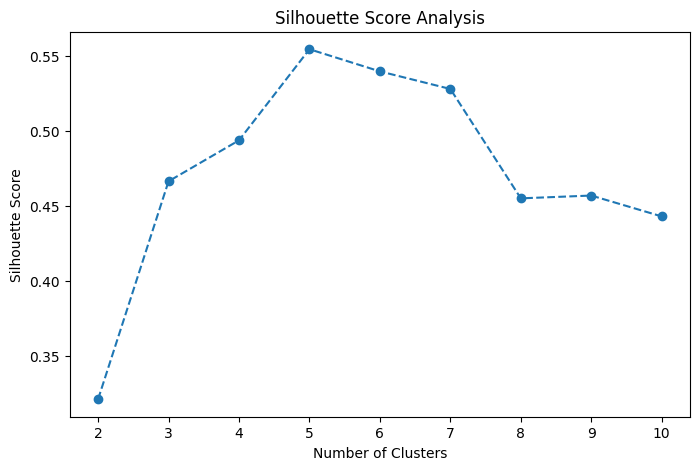

In [28]:
silhouette_scores = []

for k in range(2, 11):  # Start from 2 as silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette Score Graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')
plt.show()

In [29]:
# Choose the optimal number of clusters based on silhouette score
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Since range starts at 2

# Train final KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster'], palette='viridis', s=100)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segments')
plt.legend()
plt.show()

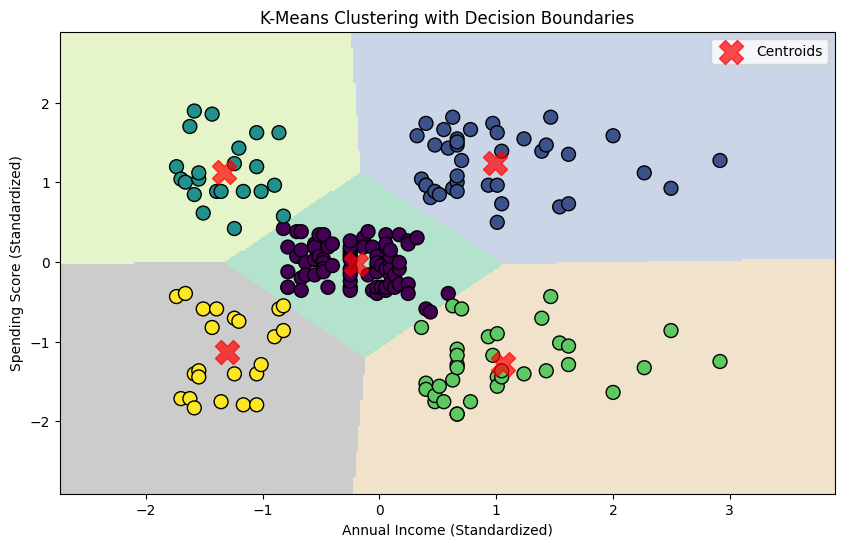

In [31]:
h = 0.02  
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2, aspect='auto', origin='lower')

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['Cluster'], s=100, cmap='viridis', edgecolors='k')

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', alpha=0.7, label='Centroids')

plt.xlabel('Annual Income (Standardized)')
plt.ylabel('Spending Score (Standardized)')
plt.title('K-Means Clustering with Decision Boundaries')
plt.legend()
plt.show()

In [32]:
print("Number of customers in each cluster:")
print(df['Cluster'].value_counts())

Number of customers in each cluster:
Cluster
0    81
1    39
3    35
4    23
2    22
Name: count, dtype: int64


In [33]:
cluster_summary = df.groupby('Cluster').mean()
print("\nCluster-wise summary statistics:")
print(cluster_summary)


Cluster-wise summary statistics:
           Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.592593  42.716049           55.296296               49.518519
1        0.538462  32.692308           86.538462               82.128205
2        0.590909  25.272727           25.727273               79.363636
3        0.457143  41.114286           88.200000               17.114286
4        0.608696  45.217391           26.304348               20.913043


In [34]:
print(df.head())
print(df.tail())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0       0   19                  15                      39        4
1       0   21                  15                      81        2
2       1   20                  16                       6        4
3       1   23                  16                      77        2
4       1   31                  17                      40        4
     Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
195       1   35                 120                      79        1
196       1   45                 126                      28        3
197       0   32                 126                      74        1
198       0   32                 137                      18        3
199       0   30                 137                      83        1


In [35]:
df.to_csv('Clustered_Customers.csv', index=False)
print("Clustered data saved as 'Clustered_Customers.csv'")

Clustered data saved as 'Clustered_Customers.csv'


In [36]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(X_scaled, df['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

Davies-Bouldin Index: 0.5722


In [37]:
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.5547
